<b><font size = '6'>Analyze A/B test results</b>

<b><font size = '4'>Part-I : Probability</b>

In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
#Setting seed, to get same results everytime
random.seed(42)

In [3]:
#Loading data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape

(294478, 5)

In [5]:
df['user_id'].nunique()

290584

In [6]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [7]:
#Finding the mean of converts
df['converted'].mean()

0.11965919355605512

In [8]:
control_new = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]
treatment_old = df[(df['group'] == 'treatment') &  (df['landing_page'] == 'old_page')]

In [9]:
control_new.shape[0], treatment_old.shape[0]

(1928, 1965)

In [10]:
control_new.shape[0] + treatment_old.shape[0]

3893

In [11]:
#As this instances of dataset are uninterpretable, we will remove this instances.
df_remove_instances = control_new.append(treatment_old).index
df_remove_instances

Int64Index([    22,    240,    490,    846,    850,    988,   1198,   1354,
              1474,   1877,
            ...
            293240, 293302, 293391, 293443, 293530, 293773, 293817, 293917,
            294014, 294252],
           dtype='int64', length=3893)

In [12]:
df2 = df.drop(df_remove_instances)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [13]:
#Check if all uninterpretable instances are removed.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [14]:
df2['user_id'].nunique()

290584

In [15]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

In [16]:
df2.drop(2893, inplace = True)

In [17]:
converted_mean = df2['converted'].mean()
converted_mean

0.11959708724499628

In [18]:
#conversion rate for control/old
converted_control = df2[df2['group'] == 'control']['converted'].mean()
converted_control

0.1203863045004612

In [19]:
#conversion rate for treatment/new
converted_treatment = df2[df2['group'] == 'treatment']['converted'].mean()
converted_treatment

0.11880806551510564

In [20]:
p_newpage = (df2['landing_page'] == 'new_page').mean()
p_newpage

0.5000619442226688

The proportions of page are balanced, so there is no need for additional manipulation.

<b>Observation:</b> There is no sufficient evidence to say if treatment group is better than control group that leads to more conversions.

<b><font size = '4'>Part-II : A/B Testing

<b>Hypotheses: </b>
$$
H_0 : p_{new} - p_{old} \leq 0 \\
H_1 : p_{new} - p_{old} &gt; 0
$$
   

In [21]:
converted_mean

0.11959708724499628

In [22]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

In [23]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

In [24]:
#conversions for new page
new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - converted_mean), converted_mean])
#conversions for old page
old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - converted_mean), converted_mean])

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0009959967844151707

In [28]:
#Running 10000 simulations
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - converted_mean), converted_mean])
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - converted_mean), converted_mean])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [29]:
p_diff = np.asarray(p_diffs)

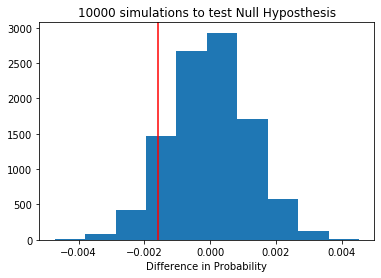

In [32]:
plt.hist(p_diffs)
plt.title('10000 simulations to test Null Hyposthesis')
plt.xlabel('Difference in Probability')
plt.axvline(converted_treatment - converted_control, color = 'r')

In [33]:
o_diff = converted_treatment - converted_control
(p_diff > o_diff).mean()

0.9069

<b>Result:</b> The calculated p-value is 0.9069. This is much greater than the $\alpha$ value which is 0.05. From the observations, we are failed to reject the null and don't have sufficient evidence to say new_page/treatment group is responsible for more conversion rate.

<b><font size = '4'>Part-III : A Regression Approach

<b>Logistic Regression</b>

In [35]:
#Get dummy variables for landing_page
df2[['testing_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,testing_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


In [36]:
import statsmodels.api as sm

In [37]:
log_reg = sm.Logit(df2['converted'], df2[['intercept', 'testing_page']])
result = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 29 Nov 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:55:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9888      0.008   -246.669      0.000      -2.005      -1.973
testing_page    -0.0150      0.011     -1.311      0.190      -0.037       0.007
================================================================================
"""

<b>Result: </b>As the p value here is 0.190, still remains above than $\alpha$, we fail to reject the null.

Now, we are adding a country column to our dataset. We will build a model to test if country of the user affects the conversion rates between old and new pages.

In [39]:
countries = pd.read_csv('countries.csv')
df3 = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
df3.head()

,country,timestamp,group,landing_page,converted,testing_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [41]:
df3['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [42]:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.head()

,country,timestamp,group,landing_page,converted,testing_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [44]:
log_reg = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']])
result = log_reg.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 29 Nov 2020   Pseudo R-squ.:               1.521e-05
Time:                        21:06:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

<b>Result:</b> Again, all the p-values are greater than $\alpha$, we fail to reject the null. So, we conclude that, the country doesn't affect the differences in conversion rates of old page and new page.

In [45]:
df3['CA_tests'] = df3['CA'] * df3['testing_page']
df3['UK_tests'] = df3['UK'] * df3['testing_page']
df3.head()

,country,timestamp,group,landing_page,converted,testing_page,old_page,intercept,CA,UK,US,CA_tests,UK_tests
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [46]:
log_reg = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK', 'CA_tests', 'UK_tests']])
result = log_reg.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 29 Nov 2020   Pseudo R-squ.:               2.417e-05
Time:                        21:12:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK             0.0045      0.018      0.257      0.797      -0.030       0.039
CA_tests      -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_tests       0.0108      0.023      0.475      0.635      -0.034       0.056
==============================================================================
"""

<b>Result:</b> Once again, all the p-values are greater than $\alpha$ value, so we fail to reject the null. And we can conclude that no interaction between country and page is affecting the conversion rate of the page.

Overall, from all the observations, we do not have sufficient evidence to conclude that the new page attracts more users to convert than the old page.